최종수정일시 : 2021-05-11 (모델링2)

#### - 기본 Feature : D_TYPE, GOODS_TYPE, AD1
#### - DATE 관련 추가 Feature : month(월), day(일), dayofweek(요일), holiday(일요일,국경일), weekend_indi(금,토), 교통량합계

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')
    
# 랜덤 시드 생성
np.random.seed(42)

### 데이터 불러오기 (미리 날짜별로 저장)

In [143]:
train = pd.read_csv('train.csv',encoding='ansi')
test = pd.read_csv('test.csv',encoding='ansi')
trans = pd.read_csv('교통량통합.csv',encoding='ansi')

### 교통량 합계 데이터 train, test 분할

In [144]:
trans['DATE'] = pd.to_datetime(trans['DATE'])
trans.set_index('DATE',inplace=True)

trans_train = trans.loc[:'2020-09-30']
trans_test = trans.loc['2020-10-01':]

trans_train.reset_index(inplace=True)
trans_test.reset_index(inplace=True)

### DATE 컬럼 데이터타입 datetime으로 변경 후 교통량 합계와 병합

In [145]:
train['DATE']=pd.to_datetime(train['DATE'])
test['DATE']=pd.to_datetime(test['DATE'])

train = pd.merge(train,trans_train, how='left', left_on='DATE', right_on='DATE')
test = pd.merge(test,trans_test, how='left', left_on='DATE', right_on='DATE')

### 교통량합계 MinMax Scaling

In [146]:
from sklearn import preprocessing

train[['교통량합계']] = preprocessing.MinMaxScaler().fit(train[['교통량합계']]).transform(train[['교통량합계']])
test[['교통량합계']] = preprocessing.MinMaxScaler().fit(test[['교통량합계']]).transform(test[['교통량합계']])

### 레이블(x)과 타겟(y)분리

In [147]:
train_X = train.drop('COUNT',axis=1)
train_y = train[['COUNT']]

test_X = test.drop('COUNT',axis=1)
test_y = test[['COUNT']]

### 필요없는 컬럼 제거

In [148]:
train_X.drop(['Unnamed: 0','USER_ID','JOIN_DATE','STORE_ID'],axis=1,inplace=True)
test_X.drop(['Unnamed: 0','USER_ID','JOIN_DATE','STORE_ID'],axis=1,inplace=True)

### 레이블인코딩 (문자형 -> 숫자형)

In [149]:
# Feature Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

train_X['D_TYPE'] = le.fit_transform(train_X['D_TYPE'])
train_X['GOODS_TYPE'] = le.fit_transform(train_X['GOODS_TYPE'])
train_X['AD1'] = le.fit_transform(train_X['AD1'])

test_X['D_TYPE'] = le.fit_transform(test_X['D_TYPE'])
test_X['GOODS_TYPE'] = le.fit_transform(test_X['GOODS_TYPE'])
test_X['AD1'] = le.fit_transform(test_X['AD1'])

### 월,일 컬럼 생성

In [150]:
train_X['Month'] = [k for k in train_X['DATE'].dt.month]
test_X['Month'] = [k for k in test_X['DATE'].dt.month]

In [151]:
train_X['Day'] = [k for k in train_X['DATE'].dt.day]
test_X['Day'] = [k for k in test_X['DATE'].dt.day] 

### 요일 컬럼 생성 {월:0, 화:1, 수:2, 목:3, 금:4, 토:5, 일:6}

In [152]:
## 요일 컬럼 생성
train_X['dayofweek'] = [k for k in train_X['DATE'].dt.dayofweek]
test_X['dayofweek'] = [k for k in test_X['DATE'].dt.dayofweek] 

### holiday 컬럼 생성 (구매율이 낮았던 일요일과 국경일)

In [153]:
# 2020년 holiday 지정
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday

class Calendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('KR_New Year1', month=1, day=24),
        Holiday('KR_New Year2', month=1, day=25),
        Holiday('KR_New Year3', month=1, day=26),
        Holiday('3.1', month=3, day=1),
        Holiday('Buddha Day', month=4, day=30),
        Holiday('Memorial Day', month=6, day=6),
        Holiday('Liberation Day', month=8, day=15),
        Holiday('KR_Thanksgiving1', month=9, day=30),
        Holiday('KR_Thanksgiving2', month=10, day=1),
        Holiday('KR_Thanksgiving3', month=10, day=2),
        Holiday('National Foundation Day', month=10, day=3),
        Holiday('Hangul Day', month=10, day=9),
        Holiday('Christmas', month=12, day=25)
    ]
dr = pd.date_range(start='2020-01-01', end='2020-12-31')
cal = Calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
train_X['Holiday'] = train_X['DATE'].isin(holidays)
test_X['Holiday'] = test_X['DATE'].isin(holidays)

# 일요일도 holiday로
for i in range(len(train_X)):
    if train_X['Day'][i] == 6:
        train_X['Holiday'][i] = True
        
for i in range(len(test_X)):
    if test_X['Day'][i] == 6:
        test_X['Holiday'][i] = True

### Weekend_indi 컬럼 생성 (구매율이 높았던 금,토)

In [154]:
train_X['Weekend_indi'] = 0
train_X['EveryDay'] = train_X.loc[train_X['Day'].isin([4,5]), 'Weekend_indi'] =1

In [155]:
test_X['Weekend_indi'] = 0
test_X['EveryDay'] = test_X.loc[test_X['Day'].isin([4,5]), 'Weekend_indi'] =1

### 필요없는 컬럼 제거

In [156]:
train_X.drop(['DATE','EveryDay'],axis=1,inplace=True)
test_X.drop(['DATE','EveryDay'],axis=1,inplace=True)

In [160]:
display(train_X, test_X)

,D_TYPE,GOODS_TYPE,AD1,교통량합계,Month,Day,dayofweek,Holiday,Weekend_indi
0,0,0,37,0.285568,1,1,2,True,0
1,1,0,46,0.285568,1,1,2,True,0
2,1,0,60,0.285568,1,1,2,True,0
3,1,2,49,0.285568,1,1,2,True,0
4,0,2,48,0.285568,1,1,2,True,0
...,...,...,...,...,...,...,...,...,...
623574,1,1,37,0.235073,9,30,2,True,0
623575,0,1,49,0.235073,9,30,2,True,0
623576,0,1,3,0.235073,9,30,2,True,0
623577,1,0,48,0.235073,9,30,2,True,0


,D_TYPE,GOODS_TYPE,AD1,교통량합계,Month,Day,dayofweek,Holiday,Weekend_indi
0,0,0,52,0.311937,10,1,3,True,0
1,1,3,50,0.311937,10,1,3,True,0
2,1,0,52,0.311937,10,1,3,True,0
3,1,0,22,0.311937,10,1,3,True,0
4,0,0,64,0.311937,10,1,3,True,0
...,...,...,...,...,...,...,...,...,...
255687,1,1,40,0.666088,12,31,3,False,0
255688,1,1,19,0.666088,12,31,3,False,0
255689,0,1,52,0.666088,12,31,3,False,0
255690,1,1,50,0.666088,12,31,3,False,0


### 랜덤포레스트 모델링

In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor()
    
rfr.fit(train_X, train_y)
    
y_pred = rfr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred)
print('MSE :', MSE)

MSE : 0.34549719031553855


### LightGBM 모델링

In [163]:
from lightgbm import LGBMRegressor

lgbr = LGBMRegressor(n_estimators=400)

lgbr.fit(train_X, train_y)

y_pred2 = lgbr.predict(test_X)

MSE = mean_squared_error(test_y, y_pred2)
print('MSE :', MSE)

MSE : 0.3341581755717744


### LightGBM 모델의 변수 중요도

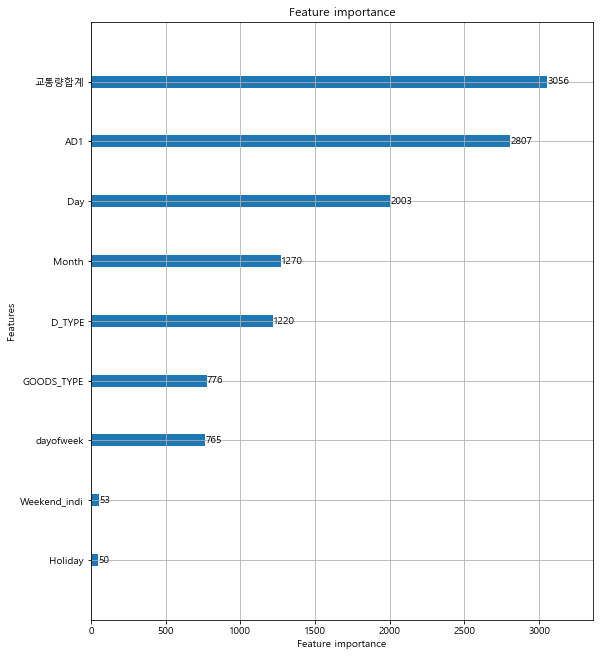

In [161]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(lgbr, ax=ax)
plt.savefig('변수의 중요도.png')

### 예측값과 원래값 비교

In [164]:
comparison = pd.DataFrame({'prediction': y_pred,
                          'ground_truth' : test_y.values.ravel()}) 
comparison

,prediction,ground_truth
0,1.000000,1
1,1.062449,1
2,1.018530,1
3,1.010000,1
4,1.153899,1
...,...,...
255687,1.002474,1
255688,1.000000,1
255689,1.039735,1
255690,1.008449,1


In [165]:
comparison.to_csv('비교.csv',encoding='ansi')